# Analysis of hazardous asteroids' orbital parameters

Using data on already discovered asteroid's we'll try to analyse orbital parameters of near-Earth asteroids and  find out familes of orbits with high probability of yet undiscovered potentially hazardous asteroids existance.

In [1]:
%matplotlib inline
import itertools
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
import pickle, sys, os, time
import numpy as np
# import pandas as pd
import scipy.stats as ss
from sklearn import neighbors, svm
from sklearn.neighbors.kde import KernelDensity

import read_database as rdb
import generate_orbits as go
import learn_data as ld
import visualize_data as vd
import asterion_learn as al
from copy import deepcopy

font = {'size': 14}
matplotlib.rc('font', **font)

### ASTEROID DATABASE

**Load asteroid database:**

In [2]:
columns = ['a', 'e', 'i', 'w', 'om', 'q', 'H', 'neo', 
               'pha', 'moid', 'per', 'n', 'ma', 'epoch']

database = rdb.load_database(columns, jobtime=True)
database.head(n=5)

Loading asteroid database...
Asteroid database loaded in 6.275680 seconds.


neo pha     H      epoch         e         a         q          i  \
0   N   N  3.34  2457600.5  0.075705  2.768134  2.558572  10.591705   
1   N   N  4.13  2457600.5  0.230835  2.772779  2.132725  34.841162   
2   N   N  5.33  2457600.5  0.256601  2.668831  1.984005  12.990102   
3   N   N  3.20  2457600.5  0.089067  2.361348  2.151031   7.140406   
4   N   N  6.85  2457600.5  0.191552  2.574343  2.081222   5.367954   

           om           w          ma         n          per     moid  
0   80.314273   72.814757  224.095256  0.214005  1682.205859  1.59307  
1  173.087844  309.999215  206.286381  0.213467  1686.441928  1.23093  
2  169.862997  248.236797  168.734429  0.226059  1592.501978  1.03424  
3  103.842512  151.111635  183.876822  0.271621  1325.374085  1.13866  
4  141.591962  358.878896   43.434790  0.238619  1508.682820  1.09307

In [3]:
# TODO: exclude commets

**Extract NEOs:**

In [13]:
neo, num_neo = rdb.get_neo(database, columns)

** Extract objects with large semi-major axis **

In [14]:
neo_large_a = neo[neo.a > 4]
print len(neo_large_a)

12


In [15]:
neo = neo[neo.a < 4]
num_neo = len(neo)

**Split NEOs by groups:**

In [16]:
# apollos, num_apollos = rdb.get_apollos(neo)
# atens, num_atens = rdb.get_atens(neo)
# amors, num_amors = rdb.get_amors(neo)

# print "apollos:", num_apollos, "neo:", num_neo, "ratio:", num_apollos/float(num_neo)
# print "atens:", num_atens, "neo:", num_neo, "ratio:", num_atens/float(num_neo)
# print "amors:", num_amors, "neo:", num_neo, "ratio:", num_amors/float(num_neo)

**Cut off apollo asteroids with extreme orbital parameters:**

In [17]:
# apollos, num_apollos = rdb.cutoff_outliers(apollos)

**Extract hazardous and nonhazardous orbits from apollo group**

In [18]:
# haz_real, nohaz_real = rdb.get_hazMOID(apollos)

**Extract hazardous and nonhazardous orbits from NEOs**

In [19]:
haz_real, nohaz_real = rdb.get_hazMOID(neo)

## GENERATE RANDOM ASTEROIDS

**Specify a subset of asteroid parameters:**

In [20]:
names = ['a', 'i', 'w', 'om', 'q']
full_names = [vd.colnames[nm] for nm in names]
# data_subset = apollos[names]
data_subset = neo[names]

**Pick an appropriate range of continuous distributions to fit parameters subset:**

**Find curve-fitted continuous distributions:**

Data cdf(xmax): 1.000000 	beta_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	gilbrat_cdf(xmax): 0.996568
Data cdf(xmax): 1.000000 	uniform_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	harmonic_cdf(xmax): 0.999970
Data cdf(xmax): 1.000000 	genlogistic_cdf(xmax): 0.940343


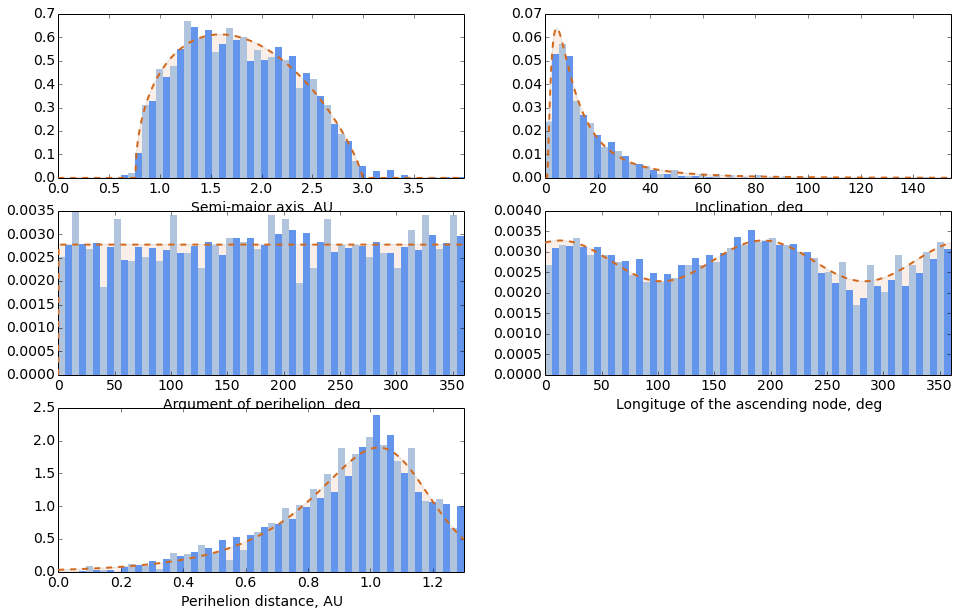

In [25]:
# statdists = [ss.johnsonsb, ss.exponweib, go.HarmonicDistribution(), 
#              go.HarmonicDistribution(), ss.genlogistic]
# ss.exponweib
statdists = [ss.beta, ss.gilbrat, ss.uniform, go.HarmonicDistribution(), ss.genlogistic] # laplace dweibull genlogistic ss.gilbrat
distlist = go.get_param_distributions(data_subset, names, statdists, n=30, verbose=True)
go.plot_param_distributions(distlist, full_names)

**Generate random asteroids on the basis of the fitted parameter distributions**

In [26]:
rnum_str = '2e5'
rnum = int(float(rnum_str))
params_minmax = go.get_param_bounds(data_subset, names)
randdata = go.gen_rand_orbits(params_minmax, names, distlist, num=rnum)

**Calculate MOID for generated virtual asteroids or load previously computed results**

In [27]:
haz_dump = './asteroid_data/neo_haz_rand_%s.p' % rnum_str
nohaz_dump = './asteroid_data/neo_nohaz_rand_%s.p' % rnum_str
try:
    haz_gen = rdb.loadObject(haz_dump)
    nohaz_gen = rdb.loadObject(nohaz_dump)
except:
    rdb.calc_moid(randdata, jobtime=True)
    haz_gen, nohaz_gen = rdb.get_hazMOID(randdata)
    
    rdb.dumpObject(haz_gen, haz_dump)
    rdb.dumpObject(nohaz_gen, nohaz_dump)

init MOID copmutation...
MOID copmutation finished in 1447.319538 seconds.


**Generate additional set of uniformly distributed virtual asteroids:**

In [30]:
unum_str = '1e5'
unum = int(float(unum_str))
statdists_u = [ss.uniform]*len(names)
distlist_u = go.get_param_distributions(data_subset, names, statdists_u, n=30, verbose=True)
params_minmax = go.get_param_bounds(data_subset, names)
randdata_u = go.gen_rand_orbits(params_minmax, names, distlist_u, num=unum)

Data cdf(xmax): 1.000000 	uniform_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	uniform_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	uniform_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	uniform_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	uniform_cdf(xmax): 1.000000


**Calculate MOID for uniformly distributed virtual asteroids or load previously computed results**

In [31]:
haz_dump = './asteroid_data/neo_haz_genu_%s.p' % unum_str
nohaz_dump = './asteroid_data/neo_nohaz_genu_%s.p' % unum_str
try:
    haz_genu = rdb.loadObject(haz_dump)
    nohaz_genu = rdb.loadObject(nohaz_dump)
except:
    rdb.calc_moid(randdata_u, jobtime=True)
    haz_genu, nohaz_genu = rdb.get_hazMOID(randdata_u)

    rdb.dumpObject(haz_genu, haz_dump)
    rdb.dumpObject(nohaz_genu, nohaz_dump)

init MOID copmutation...
MOID copmutation finished in 779.665161 seconds.


## ANALYSE ORBITAL PARAMETERS OF VIRTUAL ASTEROIDS

In [32]:
# remove outlier from the generated dataset. needs to be fixed
# outcast_ind = nohaz_gen[nohaz_gen.a > 3].index[0]
# nohaz_gen = nohaz_gen.set_value(outcast_ind, 'a', 2.0)

**Find all possible combinations for pairs of orbital parameters**

In [33]:
datasets_real = [haz_real, nohaz_real]
datasets_gen = [haz_gen, nohaz_gen]
# vd.display_allparams(datasets_real, vd.combs, vd.colnames)

** Plot distributions of 'w' and 'q' parameters for the set of generated virtual asteroids **

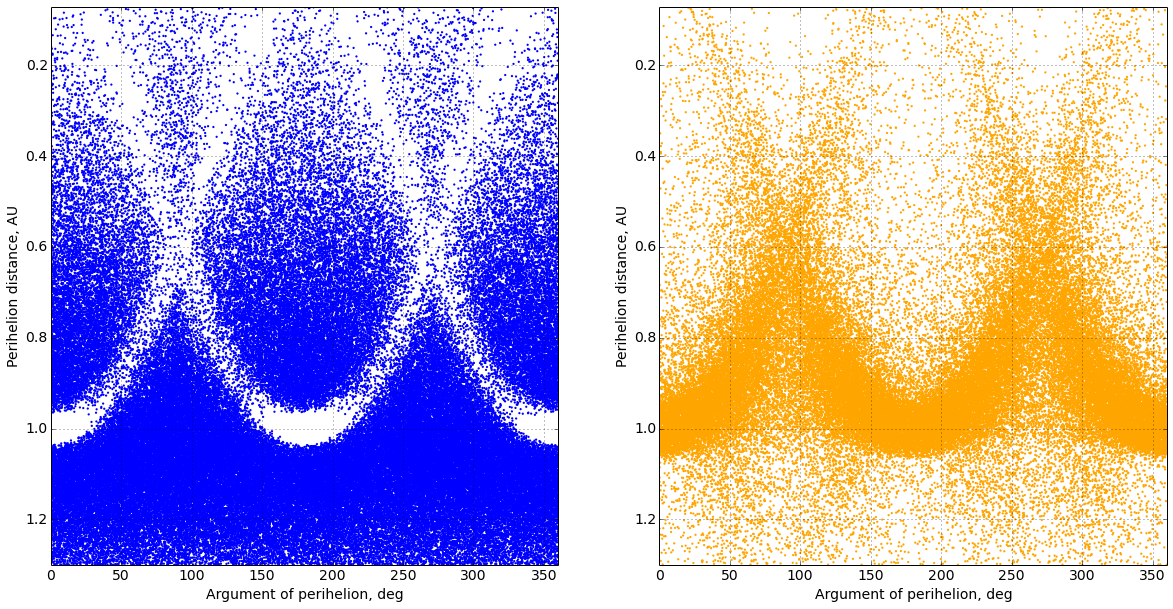

In [35]:
cols = ['w', 'q']
labels = [vd.colnames['w'], vd.colnames['q']]
vd.display_param2d(cols, labels, datasets_gen, invertaxes=[0,1])

** Plot distributions of 'w' and 'q' parameters for the set of generated uniform asteroids **

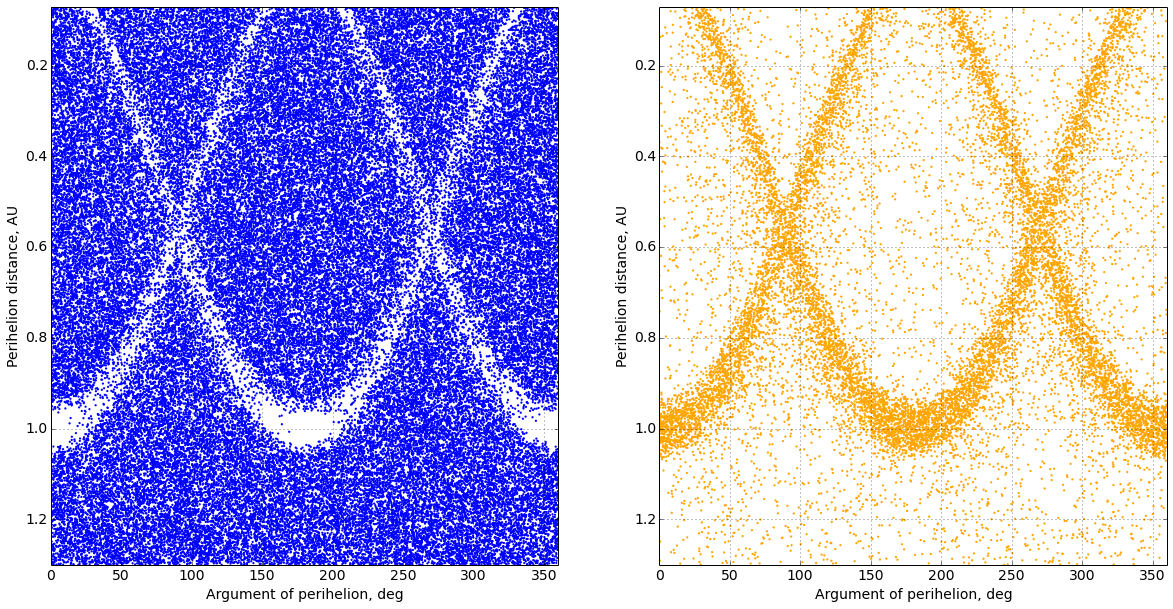

In [36]:
datasets_genu = [haz_genu, nohaz_genu]
vd.display_param2d(cols, labels, datasets_genu, invertaxes=[0,1])

### Split all apollo asteroids by several clusters

** Cut 2 parameters (w and q) from the datasets **

In [37]:
haz_real_cut, nohaz_real_cut = ld.cut_2params(cols, datasets_real)
haz_gen_cut, nohaz_gen_cut = ld.cut_2params(cols, datasets_gen)
haz_genu_cut, nohaz_genu_cut = ld.cut_2params(cols, datasets_genu)

**Normalize datasets**

In [38]:
reload(al)
bounds = al.common_bounds([haz_real_cut, nohaz_real_cut, 
                           haz_gen_cut, nohaz_gen_cut,
                           haz_genu_cut, nohaz_genu_cut])

haz_gen_cut, haz_gen_sc = al.normalize_dataset(haz_gen_cut, bounds=bounds)
nohaz_gen_cut, nohaz_gen_sc = al.normalize_dataset(nohaz_gen_cut, bounds=bounds)

haz_genu_cut, haz_genu_sc = al.normalize_dataset(haz_genu_cut, bounds=bounds)
nohaz_genu_cut, nohaz_genu_sc = al.normalize_dataset(nohaz_genu_cut, bounds=bounds)

haz_real_cut, haz_real_sc = al.normalize_dataset(haz_real_cut, bounds=bounds)
nohaz_real_cut, nohaz_real_sc = al.normalize_dataset(nohaz_real_cut, bounds=bounds)

** Get common data x and y scales **

In [39]:
scale_sets = [haz_gen_sc, nohaz_gen_sc, haz_genu_sc, 
              nohaz_genu_sc, haz_real_sc, nohaz_real_sc] 

xsc = np.asarray([list(ss[0]) for ss in scale_sets]).ravel()
ysc = np.asarray([list(ss[1]) for ss in scale_sets]).ravel()
scales = [(xsc.min(), xsc.max()), (ysc.min(), ysc.max())]
# print scales

**Split data by clusters based on uniform dataset**

In [147]:
# DBSCAN parameters
eps = [0.021]
min_samples = [91]
dens_layers = zip(eps, min_samples)
extracted_clusters = al.extract_dbclusters(nohaz_genu_cut, dens_layers)

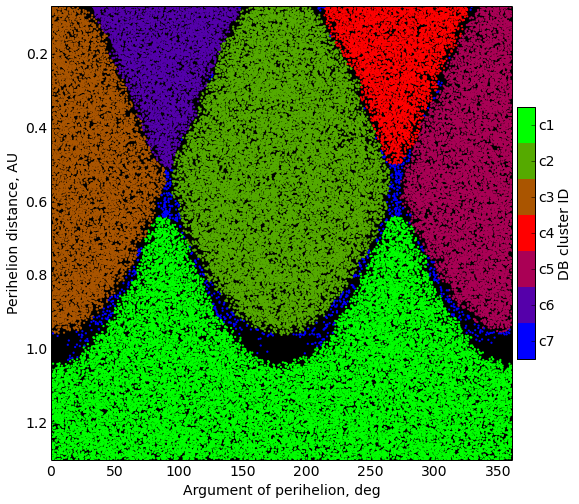

In [148]:
# reload(vd)
vd.plot_densclusters(extracted_clusters, labels=labels, cmap='brg', 
                     scales=scales, invertaxes=[0, 1], figsize=(8,7))

** Merge symmetric clusters**

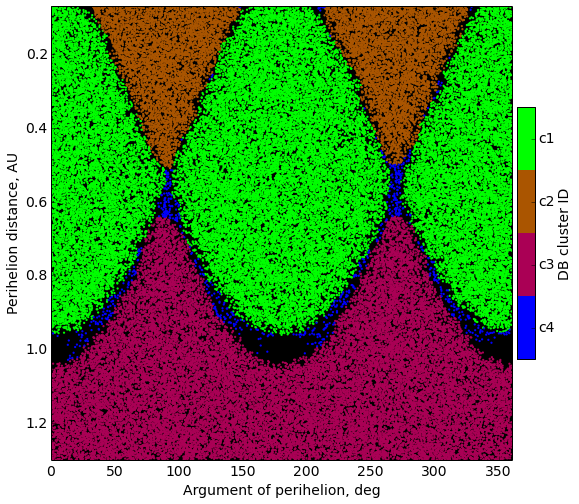

In [149]:
merged_clusters = al.merge_dbclusters(extracted_clusters, [[2,3,5], [6,4]], merge_rest=False)
vd.plot_densclusters(merged_clusters, scales=scales, labels=labels, cmap='brg', invertaxes=[0, 1], figsize=(8,7))

### Transform clusters

In [184]:
c1, c2, c3, c4 = merged_clusters

** Split and merge clusters**

In [185]:
# Split last cluster by mid value of normalized q
c4_q = c4[:,1]
c41 = c4[np.where(c4_q <= 0.4)]
c42 = c4[np.where(c4_q > 0.4)]

# Chande IDs of resulting clusters
# c41[:,2] = 1.0
# c42[:,2] = 2.0

# Merge them into existing clusters
c1_ = np.concatenate((c3, c42))
c2_ = deepcopy(c1)
c3_ = np.concatenate((c2, c41))



** Set IDs of resulting clusters **

In [186]:
c1_[:,2] = 1.0
c2_[:,2] = 2.0
c3_[:,2] = 3.0


# c2x, c2y = al.split_by_lastcol(c2_)
# print np.unique(c2y)

In [187]:


# c3_q = c3_[:,1]
# c31 = c3_[np.where(c3_q <= 0.82)]
# c32 = c3_[np.where(c3_q > 0.82)]
# c31[:,2] = 2.0
# c32[:,2] = 3.0

In [188]:
# print len(c31)
# print len(c32)

In [189]:
# c1_q = c1[:,1]
# c11 = c1[np.where(c1_q <= 0.4)]
# c12 = c1[np.where(c1_q > 0.4)]
# c11[:,2] = 4.0
# c12[:,2] = 5.0

# c31 = np.concatenate((c31, c42))
# c2 = np.concatenate((c2, c41))

# c22[:,2] = 5.0

** Build new set of clusters **

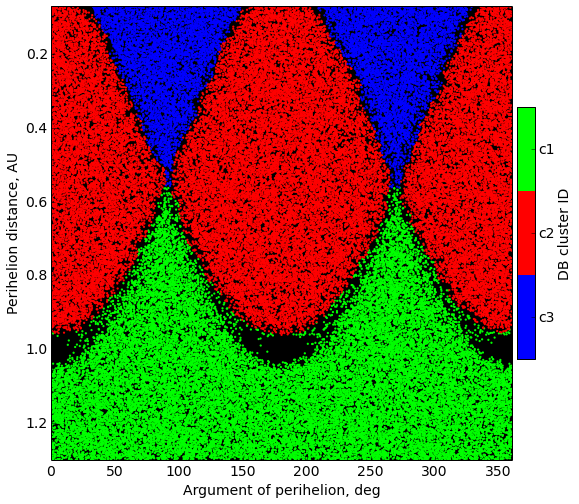

In [190]:
# reload(vd)
# split_clusters = [c11, c12, c2_, c31, c32]
split_clusters = [c1_, c2_, c3_]
# split_clusters = [c01, c11, c12]
vd.plot_densclusters(split_clusters, scales=scales, labels=labels, cmap='brg', invertaxes=[0, 1], figsize=(8,7))

**Extract hazardous belt from the generated uniform set of hazardous asteroids**

In [191]:
eps = [0.028]
min_samples = [80]
dens_layers = zip(eps, min_samples)
extracted_clusters_X = al.extract_dbclusters(haz_genu_cut, dens_layers)

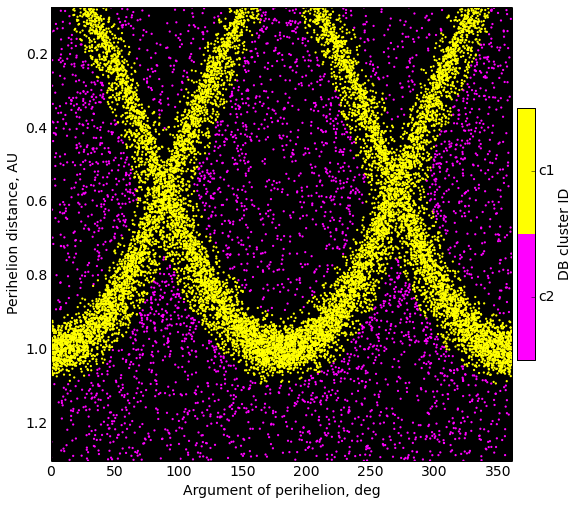

In [192]:
# reload(vd)
vd.plot_densclusters(extracted_clusters_X, scales=scales, labels=labels, cmap='spring', 
                     invertaxes=[0, 1], figsize=(8,7))

** Edit hazardous belt ID and add it to the cluster set**

In [193]:
c5[:,2] = 4.0
split_clusters.append(c5)

In [194]:
# c5 = extracted_clusters_X[0]

# c5_q = c5[:,1]
# c51 = c5[np.where(c5_q <= 0.4)]
# c52 = c5[np.where(c5_q > 0.4)]

# c51[:,2] = 6.0
# c52[:,2] = 7.0
# split_clusters.append(c51)
# split_clusters.append(c52)

## c5[:,2] = 5.0
## split_clusters.append(c5)

In [195]:
# print split_clusters[:4]

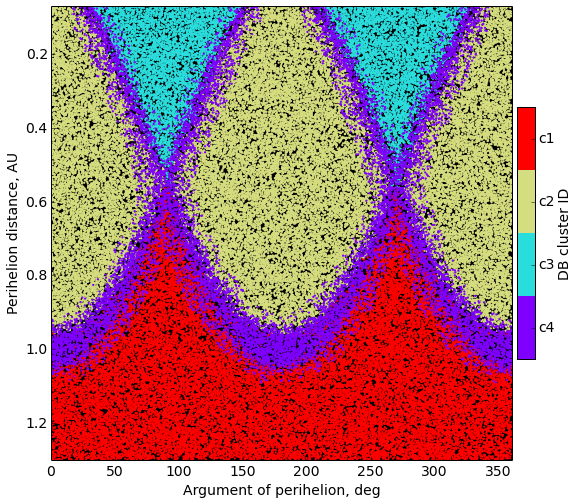

In [196]:
# reload(vd)
vd.plot_densclusters(split_clusters, scales=scales, labels=labels, cmap='rainbow', 
                     invertaxes=[0, 1], figsize=(8,7))

### Train SVM classifier using clusters' IDs as the class reference

In [197]:
reload(al)
clf = svm.SVC(gamma=6., C=1000)
xtrain, clf, haz_prob = al.classify_dbclusters(split_clusters, clf, haz_real_cut, nohaz_real_cut)

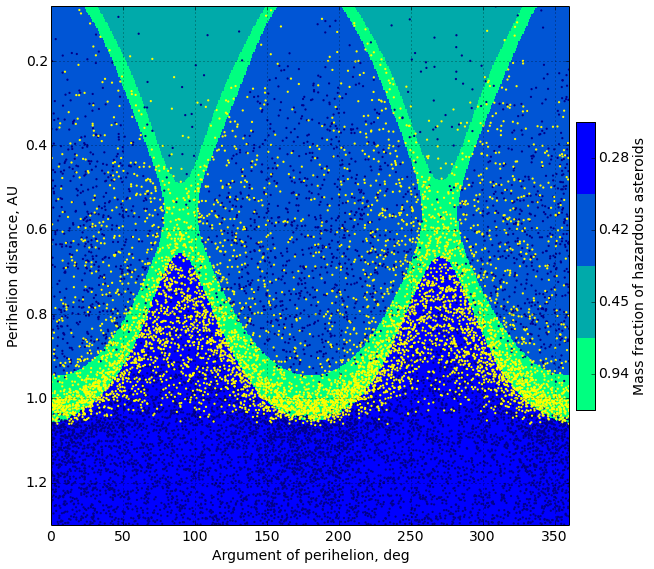

In [198]:
reload(vd)
# haz=haz_real_cut, nohaz=nohaz_real_cut,
# scales=scales
# rescale=False
vd.plot_classifier(xtrain, clf, num=400, haz=haz_real_cut, nohaz=nohaz_real_cut, figsize=(9,8),
                   clustprobs=haz_prob[1:], labels=labels, invertaxes=[0, 1], scales=scales,
                   cmap='winter')

** Load uniform asteroids with high dencity **

In [34]:
# haz_genu2 = rdb.loadObject('./asteroid_data/haz_genu_15e4.p')
# nohaz_genu2 = rdb.loadObject('./asteroid_data/nohaz_genu_15e4.p')

In [42]:
# haz_genu_cut, nohaz_genu_cut = ld.cut_2params(cols, [haz_genu, nohaz_genu])
# haz_genu_cut, sc_ = al.normalize_dataset(haz_genu_cut)
# nohaz_genu_cut, sc_ = al.normalize_dataset(nohaz_genu_cut)

**Classify generated sets of asteroids by cluster IDs**

In [199]:
haz_classify = clf.predict(haz_gen_cut)
nohaz_classify = clf.predict(nohaz_gen_cut)

In [200]:
hazu_classify = clf.predict(haz_genu_cut)
nohazu_classify = clf.predict(nohaz_genu_cut)

** Export obtained asteroid subgroubs **

In [201]:
def export_subgroups(sg_ids, nmb, cls, dbs):
    
    haz_nmb = dirpath + nmb[0]
    nohaz_nmb = dirpath + nmb[1]
    haz_db, nohaz_db = dbs
    haz_cls, nohaz_cls = cls

    for i in sg_ids:
        haz_inds = np.where(haz_cls == i)[0]
        nohaz_inds = np.where(nohaz_cls == i)[0]
        haz_rest_inds = np.where(haz_cls != i)[0]
        nohaz_rest_inds = np.where(nohaz_cls != i)[0]
        
        haz_gen_sg = haz_db.iloc[haz_inds]
        nohaz_gen_sg = nohaz_db.iloc[nohaz_inds]
        haz_gen_rest = haz_db.iloc[haz_rest_inds]
        nohaz_gen_rest = nohaz_db.iloc[nohaz_rest_inds]
        
        haz_name = haz_nmb %i
        nohaz_name = nohaz_nmb %i
        haz_name_rest = haz_name[:-2] + '_rest.p'
        nohaz_name_rest = nohaz_name[:-2] + '_rest.p'
        
        rdb.dumpObject(haz_gen_sg, haz_name)
        rdb.dumpObject(nohaz_gen_sg, nohaz_name)
        rdb.dumpObject(haz_gen_rest, haz_name_rest)
        rdb.dumpObject(nohaz_gen_rest, nohaz_name_rest)


In [202]:
dirpath = './asteroid_data/'

haz_nmb = 'haz_gen_sg%d.p'
nohaz_nmb = 'nohaz_gen_sg%d.p'

hazu_nmb = 'haz_genu_sg%d.p'
nohazu_nmb = 'nohaz_genu_sg%d.p'
      
sg_ids = range(1, len(split_clusters) + 1)

In [203]:
export_subgroups(sg_ids, [haz_nmb, nohaz_nmb], [haz_classify, nohaz_classify], [haz_gen, nohaz_gen])

In [204]:
export_subgroups(sg_ids, [hazu_nmb, nohazu_nmb], [hazu_classify, nohazu_classify], [haz_genu, nohaz_genu])